In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Derivative of a simple function with one input

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

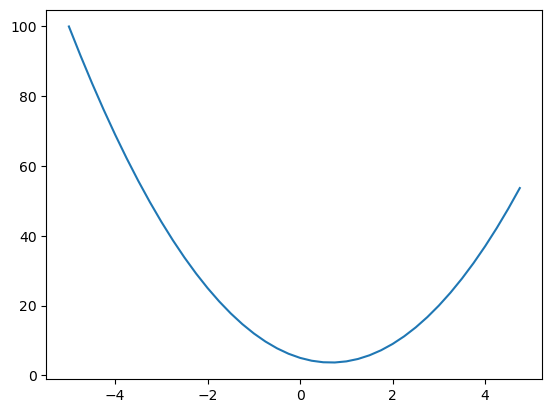

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# derivative of the slope at point 3
h = 0.00000001
x = 3
(f(x + h) - f(x))/h 

14.00000009255109

In [6]:
# derivative of the slope at point -3
h = 0.00000001
x = -3
(f(x + h) - f(x))/h

-22.00000039920269

In [7]:
# derivative of the slope at point 2/3
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

# Derivative of a function with a multiple inputs

In [8]:
# let's get more complex
a = 2.0
b = -3.0
c = 10
d = a*b + c

print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
a += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h) # derivative of the d1 with a respect to a


d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


A derivative is -3, which is the value of b. We can also calculate this analytically(mathematically). 
$\frac{dd1}{da}=b$  	

In [10]:
# inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
b += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h) # derivative of the d1 with a respect to b


d1: 4.0
d2: 4.0002
slope: 2.0000000000042206


In [11]:
# inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
c += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h) # derivative of the d1 with a respect to c

d1: 4.0
d2: 4.0001
slope: 0.9999999999976694


# Starting the core Value object of micrograd and its visualization

Now that we have some intuitive sense of what the derivative tells us about the function, let's move to the neural networks.
Neural networks are massive mathematical expressions, so we need some data structure that maintains these expressions. That's what we are going to start building here, Value object.

In [12]:
class Value():
    
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10)
#(a.__mul__(b)).__add__(c)
d = a*b + c
d

Value(data=4.0)

In [13]:
class Value():
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
#(a.__mul__(b)).__add__(c)
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [14]:
d._prev

{Value(data=-6.0), Value(data=10)}

In [15]:
d._op

'+'

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


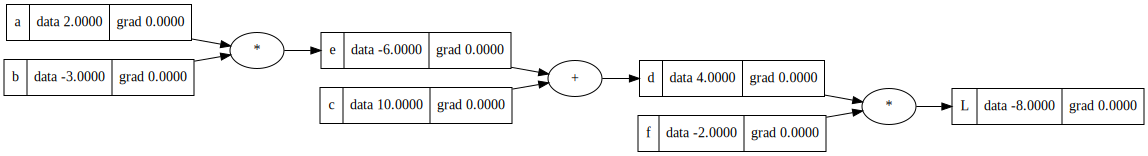

In [17]:
draw_dot(L)

# Manual backpropagation example #1: simple expression

In [18]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

0.0


In [19]:
lol()

0.0


dL/dd = ? #how L responds to the increase in d  
L = d * f  

(f(x+h) - f(x))/h  
((d+h)*f - d*f)/h  
(d*f + h*f -d*f)/h  
(h*f)/f  
= f

dd/dc = ? #how d responds to the increase in c  
d = c + e  

(f(x+h) - f(x))/h  

((c + h + e) - (c + e))/h  
(c + h + e - c - e)/h  
(h)/h  
= 1

dL/dc = ? #how L responds to the increase in c

dL/dc = (dL / dd) * (dd / dc) #chain rule  
dL/dc = -2 * 1 = -2

dL/de = -2.0  
dL/da = (dL/de) * (de/da)  

e = a * b  
de/da = b = -3   
de/db = a = 2

dL/da = -2 * -3 = 6  
dL/db = -2 * 2 = -4

In [20]:
L.grad = 1.0
f.grad = 4
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
b.grad = -4
a.grad = 6.0

In [21]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


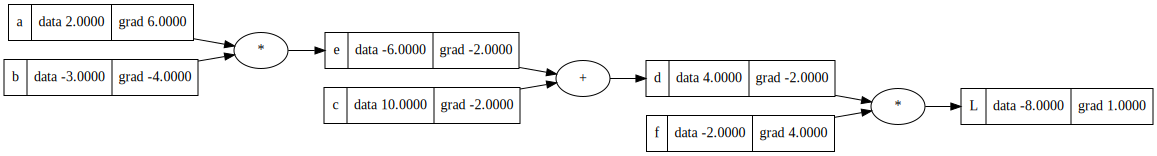

In [22]:
draw_dot(L)

Backpropagation is a recursive application of a chain rule backwards trough the computation graph.

# Preview of a single optimization step

In [23]:
# nudging leaf nodes by some small amount in the direction of gradient 
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# running forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


# Manual backpropagation example #2: a neuron

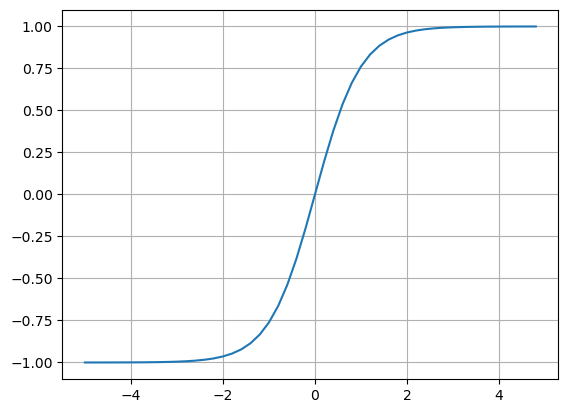

In [24]:
# tanh -- activation(squashing) function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Two neurons example:

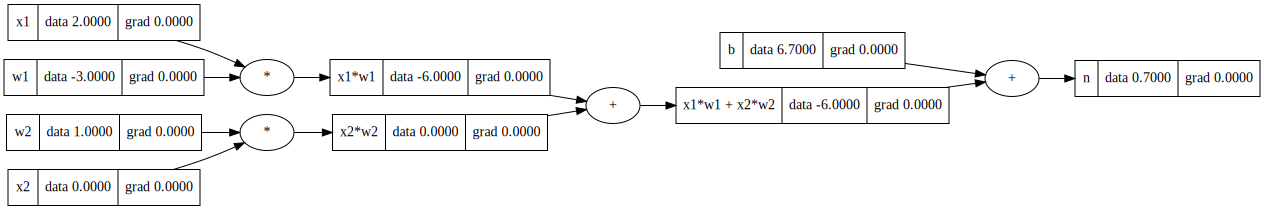

In [25]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)

In [26]:
# implementing tanh
class Value():
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

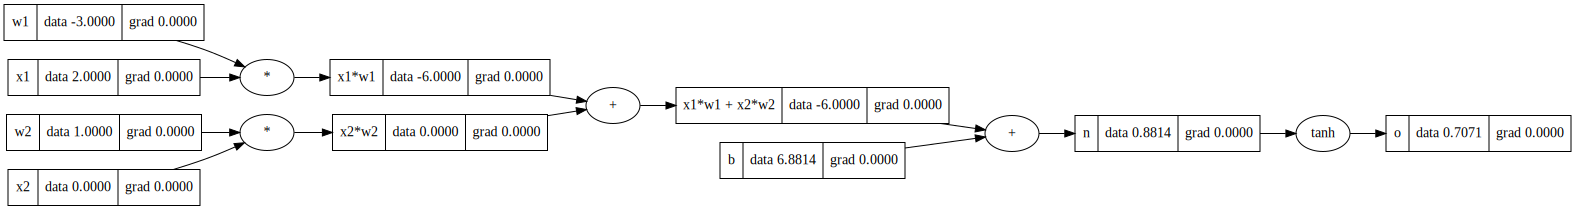

In [27]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [28]:
o.grad = 1

In [29]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2

n.grad = 1 - o.data**2
n.grad 

0.4999999999999999

In [30]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [31]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [32]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [33]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

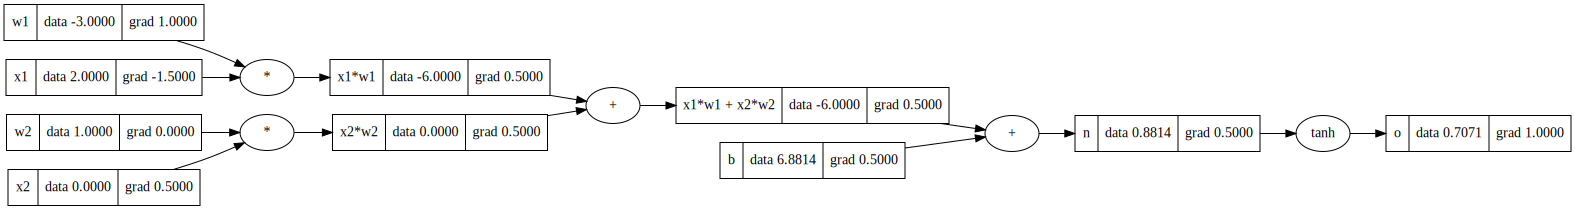

In [34]:
draw_dot(o)

# Implementing the backward function for each operation

In [35]:
# implementing backward
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [36]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

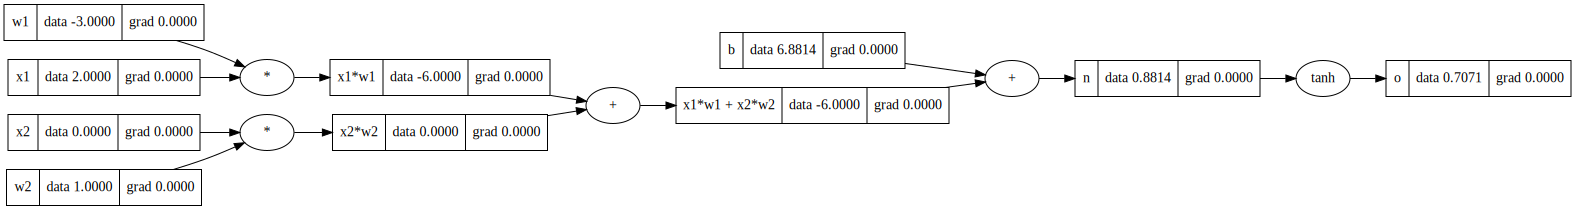

In [37]:
draw_dot(o)

In [38]:
o.grad = 1

In [39]:
o._backward()

In [40]:
n._backward()

In [41]:
b._backward() # nothing will happpeb because b is a leaf node (self._backward = lambda: None)

In [42]:
x1w1x2w2._backward()

In [43]:
x2w2._backward()

In [44]:
x1w1._backward()

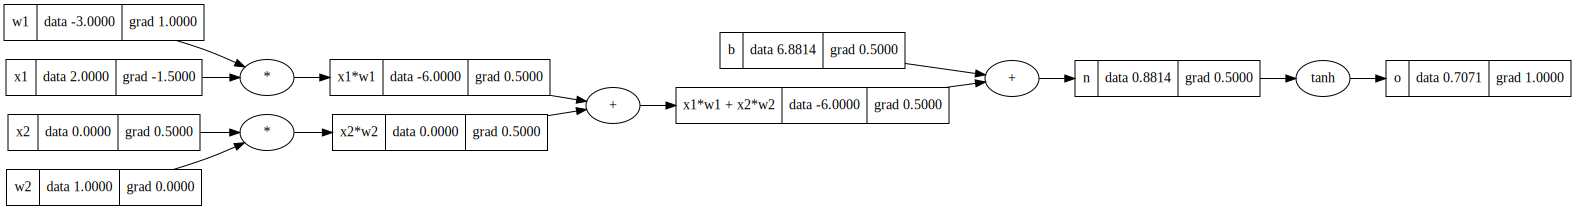

In [45]:
draw_dot(o)

In [46]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [47]:
o.grad = 1

# building topological sort 
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
  node._backward()

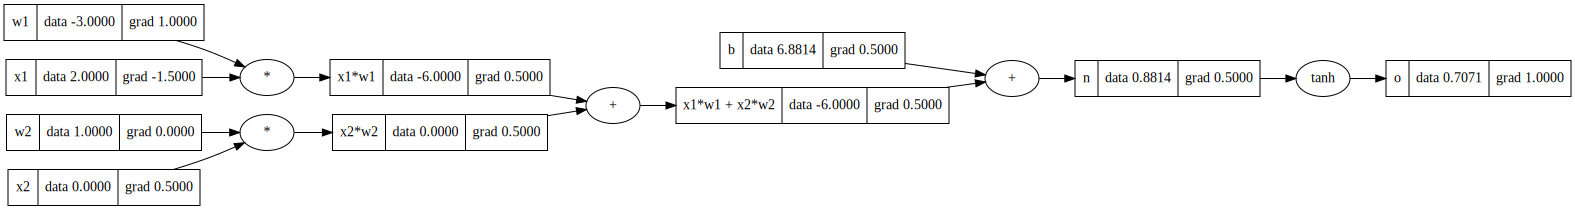

In [48]:
draw_dot(o)

In [49]:
# implementing topo
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [50]:
o._backward()

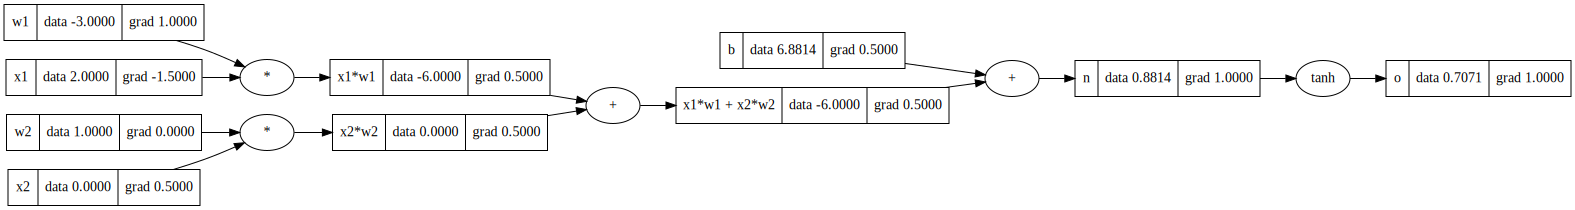

In [51]:
draw_dot(o)

# Fixing a backprop bug when one node is used multiple times

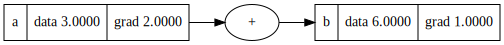

In [52]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

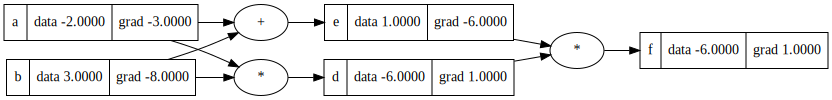

In [53]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

# Breaking up a tanh, exercising with more operations

In [54]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [55]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

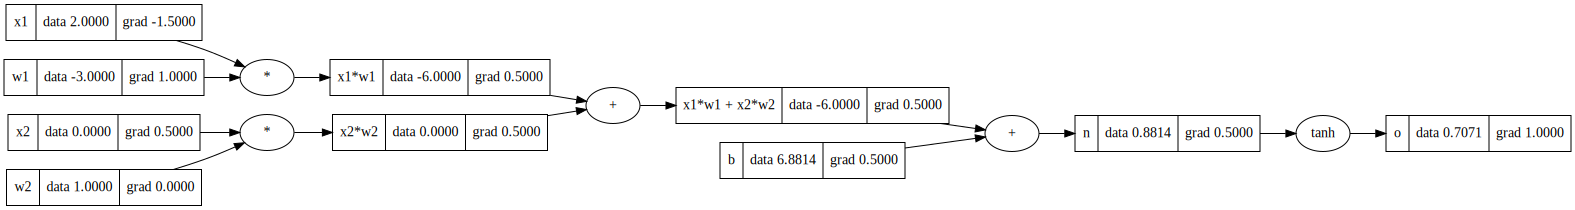

In [56]:
draw_dot(o)

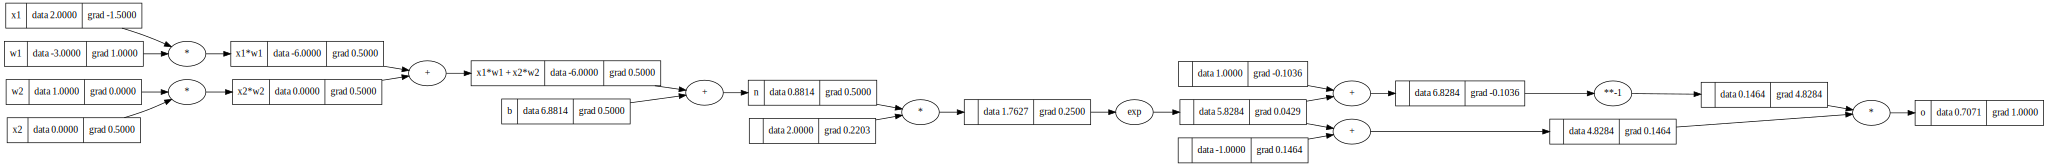

In [57]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

# Doing the same thing but in PyTorch: comparison

In [58]:
import torch

In [102]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [103]:
print(x2.grad)
print(x2.grad.item())

tensor([0.5000], dtype=torch.float64)
0.5000001283844369


In [110]:
x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.item())

o.backward()


0.7071066904050358


In [116]:
n.grad

/tmp/ipykernel_175213/2253581539.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/build/aten/src/ATen/core/TensorBody.h:480.)
  n.grad


In [117]:
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Building out a neural net library (multi-layer perceptron) in micrograd

![neuron_model](images/neuron_model.jpeg)

![neural_net](images/neural_net2.jpeg)

In [293]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) #activation
        out = act.tanh() # activation function
        return out


In [296]:
x = [2.0, 3.0] # input data
n = Neuron(2)  # number of neurons
n(x)

Value(data=0.9719696906285737)

In [299]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

In [300]:
x = [2.0, 3.0] # input data
l = Layer(2,3) # 3 neurons each having 2 inputs 
l(x)

[Value(data=0.9998404230618075),
 Value(data=0.6084969750445892),
 Value(data=-0.9989006656967194)]

In [301]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [308]:
x = [2.0, 3.0, -1,0] # input data
nn = MLP(3, [4, 4, 1]) # 3 layers of neurons (4,4,1) each having 3 inputs 
nn(x)

Value(data=0.21666687169403506)

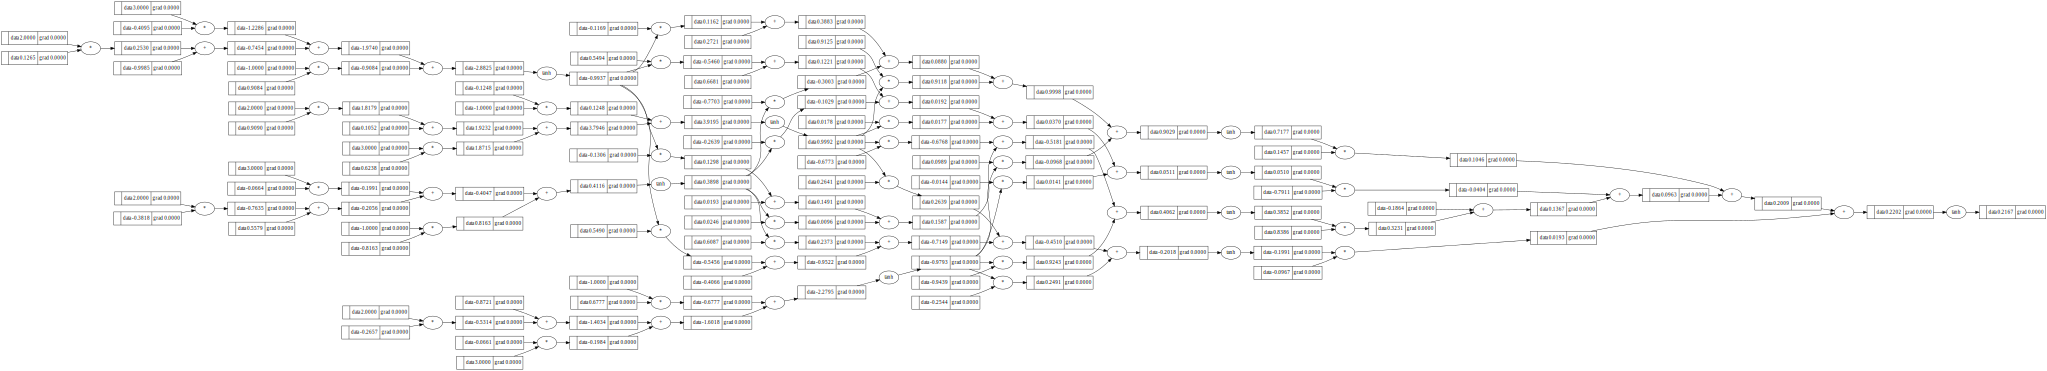

In [311]:
draw_dot(nn(x))

# Creating a tiny dataset, writing the loss function

In [376]:
class Neuron:
    
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) #activation
    out = act.tanh() # activation function
    return out

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [383]:
nn = MLP(3, [4, 4, 1]) # 3 layers of neurons (4,4,1) each having 3 inputs 

In [384]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [nn(x) for x in xs]
ypred

[Value(data=-0.1973306038797946),
 Value(data=-0.9352733507518372),
 Value(data=-0.8779463938806622),
 Value(data=-0.3373894859879361)]

In [385]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=1.4336005749871537),
 Value(data=0.0041895391228947),
 Value(data=0.014897082766734453),
 Value(data=1.7886106372310757)]

In [387]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.2412978341078587)

In [389]:
loss.backward()

In [390]:
nn.layers[0].neurons[0].w[0].grad

-0.18695420145728447

# Collecting all of the parameters of the neural net

In [398]:
class Neuron:
    
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) #activation
    out = act.tanh() # activation function
    return out

  def parameters(self):
    return self.w + [self.b]
    
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [399]:
nn = MLP(3, [4, 4, 1]) # 3 layers of neurons (4,4,1) each having 3 inputs 

In [410]:
# dataset of 4 inputs into nn
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [nn(x) for x in xs]
ypred

[Value(data=0.13756206582614722),
 Value(data=0.9263665442898326),
 Value(data=0.13027190378159836),
 Value(data=0.21501882291931332)]

In [413]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.348397278110275)

In [415]:
loss.backward()

In [416]:
nn.layers[0].neurons[0].w[0].grad

-0.06796801942572413

In [417]:
nn.layers[0].neurons[0].w[0].data # current value of the neuron

0.7894013326059655

In [414]:
print(nn.parameters())
print(f'total parameters(w+b):{len(nn.parameters())}')

[Value(data=0.7894013326059655), Value(data=0.6732988399518656), Value(data=-0.5928240959631632), Value(data=0.488639100199165), Value(data=0.7467426296319157), Value(data=0.5217644797446697), Value(data=-0.9125748379736394), Value(data=-0.5739487676250437), Value(data=0.35055544257151383), Value(data=-0.42940435616274586), Value(data=0.04681732229424873), Value(data=-0.30405985072512176), Value(data=0.6582704470160627), Value(data=-0.1526257653354719), Value(data=0.8652244079142131), Value(data=-0.5331468282791132), Value(data=-0.03477229748793875), Value(data=-0.3679763208464175), Value(data=0.4819009166032342), Value(data=0.5428549814738508), Value(data=-0.47804663860804286), Value(data=0.6176931214005077), Value(data=-0.23598369066432068), Value(data=0.7345968715907114), Value(data=0.9446953738119925), Value(data=-0.05287841576909136), Value(data=-0.1496470123963698), Value(data=0.6190961685327272), Value(data=0.5979644636971837), Value(data=0.3233562826962779), Value(data=-0.08904

# Doing gradient descent optimization manually, training the network

In [466]:
# update parameters
for p in nn.parameters():
    p.data += -0.01 * p.grad

In [467]:
# forward pass
ypred = [nn(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.028472494527757932)

In [464]:
# backward pass
loss.backward()

In [468]:
ypred

[Value(data=0.9910284801744534),
 Value(data=-0.9995037266464953),
 Value(data=-0.9909338564350934),
 Value(data=0.8317455346405426)]

In [469]:
nn.parameters() # setting for weigths and biases taht make our predictions close to gt

[Value(data=0.8318197396741709),
 Value(data=0.7335653910697371),
 Value(data=-0.5234373003785396),
 Value(data=0.5563633926920708),
 Value(data=-0.5779783404835923),
 Value(data=0.7431629383166278),
 Value(data=-1.4133023172640433),
 Value(data=-1.1833038020090243),
 Value(data=0.2032963354652107),
 Value(data=-0.26589344335399573),
 Value(data=-0.5538366764462368),
 Value(data=-0.487799247342413),
 Value(data=0.6057216524821651),
 Value(data=-0.23357952358215497),
 Value(data=0.6058963274414062),
 Value(data=-0.6829996360004977),
 Value(data=-0.5912291092556287),
 Value(data=-0.13735266334647073),
 Value(data=0.40033556172658485),
 Value(data=-0.027493658150454972),
 Value(data=-1.1615856073130688),
 Value(data=0.5994978799059034),
 Value(data=-0.44022899510361335),
 Value(data=0.7067542693684735),
 Value(data=1.0576482398332854),
 Value(data=-0.03751164772725038),
 Value(data=-0.21818139191127497),
 Value(data=1.6061109824702573),
 Value(data=0.13479792653944944),
 Value(data=-0.794

## Implementing training loop

In [493]:
# initialize NN 
nn = MLP(3, [4, 4, 1]) # 3 layers of neurons (4,4,1) each having 4 neurons eahc of those having 3 inputs

In [494]:
# sample data(xs) and the ground truth(ys)
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [495]:
# training loop(k defines training steps)
for k in range(100):
    
    # forward pass
    ypred = [nn(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    for p in nn.parameters():
        p.grad = 0.0 
    loss.backward()

    # update parameters aka gradient descent
    for p in nn.parameters():
        p.data += -0.05 * p.grad 

    print(f'step: {k}, loss: {loss.data}')

step: 0, loss: 5.74079445178922
step: 1, loss: 3.33886858843511
step: 2, loss: 2.6858757562444366
step: 3, loss: 2.2720305686682347
step: 4, loss: 1.7013178011213705
step: 5, loss: 1.0328890757342448
step: 6, loss: 0.6018957395246738
step: 7, loss: 0.39680663983497494
step: 8, loss: 0.28823324610876777
step: 9, loss: 0.22326146289232068
step: 10, loss: 0.18065162918038816
step: 11, loss: 0.15081920340789723
step: 12, loss: 0.1288954596882604
step: 13, loss: 0.11217395753095817
step: 14, loss: 0.09904111798878251
step: 15, loss: 0.08847987810096608
step: 16, loss: 0.07981960330462762
step: 17, loss: 0.07260133325183968
step: 18, loss: 0.06650102843722408
step: 19, loss: 0.06128377047304555
step: 20, loss: 0.05677533119631807
step: 21, loss: 0.05284391434868588
step: 22, loss: 0.049388079503794535
step: 23, loss: 0.04632854618411926
step: 24, loss: 0.04360250325688202
step: 25, loss: 0.04115957696037248
step: 26, loss: 0.03895892186397572
step: 27, loss: 0.036967087488011106
step: 28, lo

In [496]:
ypred

[Value(data=0.9615187877094725),
 Value(data=-0.9823200341447897),
 Value(data=-0.9484380302031277),
 Value(data=0.9487536569682204)]

# Walkthrough of the full code of micrograd on github

# Real stuff: diving into PyTorch, finding their backward pass for tanh

# Conclusion